# Image pre-processing - 2 main steps
### Step 1: Make tiles of biopsies and glue tiles together to create training images with less noise (i.e. background)
### Step 2: Make tiles of biopsies, select the best tiles, use mask_labels to determine isup_score, and store small image
### After, for another notebook: Train model using only tile images with assigned isup_score

# Step 1: Make tiles of biopsies and glue tiles together to create training images with less noise (i.e. background)

In [1]:
# Imports here
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import os
import random
import math
import skimage.io
#from csv_loader import load_csv

# Tiff visualisation imports and downloads
import numpy as np
import tifffile as tiff

# For re-importing python modules
import importlib
#importlib.reload(csv_loader.py)

# Image manipulations
import cv2
import PIL
import matplotlib
import seaborn as sns
from IPython.display import Image, display
import openslide
from PIL import Image

In [2]:
#use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# Here are the main tile functions used to make and glue tiles
Thank you kaggle user "PAB97" for your help. Algorthims in part inspired from here: https://www.kaggle.com/rftexas/better-image-tiles-removing-white-spaces

In [3]:
# compute pathe statics (ie how much white space, make sure g and b aren't going to accept any odd colors such as a sharpie black or green)
def compute_statistics(img):
    """
    Args:
        image                  numpy.array   multi-dimensional array of the form WxHxC
    
    Returns:
        ratio_white_pixels     float         ratio of white pixels over total pixels in the image 
    """
           
    #img = skimage.io.MultiImage(image)[2]
    width, height = img.shape[0], img.shape[1]
    num_pixels = width * height
    
    num_white_pixels = 0
    green_values_img = 0
    blue_values_img = 0
    
    pixelsum=np.sum(img,axis=-1)
    num_white_pixels = int((pixelsum>620).sum())
    
    green_values_img=np.sum(img[:,:,1])
    blue_values_img=np.sum(img[:,:,2])
    
    ratio_white_pixels = num_white_pixels / num_pixels
    green_concentration = green_values_img / num_pixels
    blue_concentration = blue_values_img / num_pixels
    
    return ratio_white_pixels, green_concentration, blue_concentration
    


def select_k_best_regions(regions, k=64):
    """
    Args:
        regions               list           list of 2-component tuples first component the region, 
                                             second component the ratio of white pixels
                                             
        k                     int            number of regions to select
    """
    best_regions = [x for x in regions if x[3] > 0 and x[4] > 0]
    k_best_regions = sorted(best_regions, key=lambda tup: tup[2])[:k]
    
    return k_best_regions


def get_k_best_regions(coordinates, image, window_size=512):
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x : x+window_size, y : y+window_size, :]
    
    return regions


def generate_patches(slide_path, window_size=200, stride=135, k=64):
    
    image = skimage.io.MultiImage(slide_path)[1]
    image = np.array(image)
    
    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []
    i = 0
    
    while window_size + stride*i <= max_height:
        j = 0
        
        while window_size + stride*j <= max_width:            
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride
            
            patch = image[
                x_top_left_pixel : x_top_left_pixel + window_size,
                y_top_left_pixel : y_top_left_pixel + window_size,
                :]
            
            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)
            
            j += 1
        
        i += 1
    
    k_best_region_coordinates = select_k_best_regions(regions_container, k=k)
    k_best_regions = get_k_best_regions(k_best_region_coordinates, image, window_size)
    #excess_overlap_removed = remove_overlaps(k_best_regions, k_sample=k, k_final=16)
    
           
    return image, k_best_region_coordinates, k_best_regions #, excess_overlap_removed


def display_images(regions, title):
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    
    for i, region in regions.items():
        ax[i//8, i%8].imshow(region)
    
    fig.suptitle(title)

    
def glue_to_one_picture(image_patches, window_size=200, k=16):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in image_patches.items():
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [4]:
import time
start = time.time()

image, best_coordinates, best_regions = \
generate_patches('../input/prostate-cancer-grade-assessment/train_images/00951a7fad040bf7e90f32e81fc0746f.tiff', window_size=256, stride=166, k=64)

end = time.time()
print(end-start)

0.4456796646118164


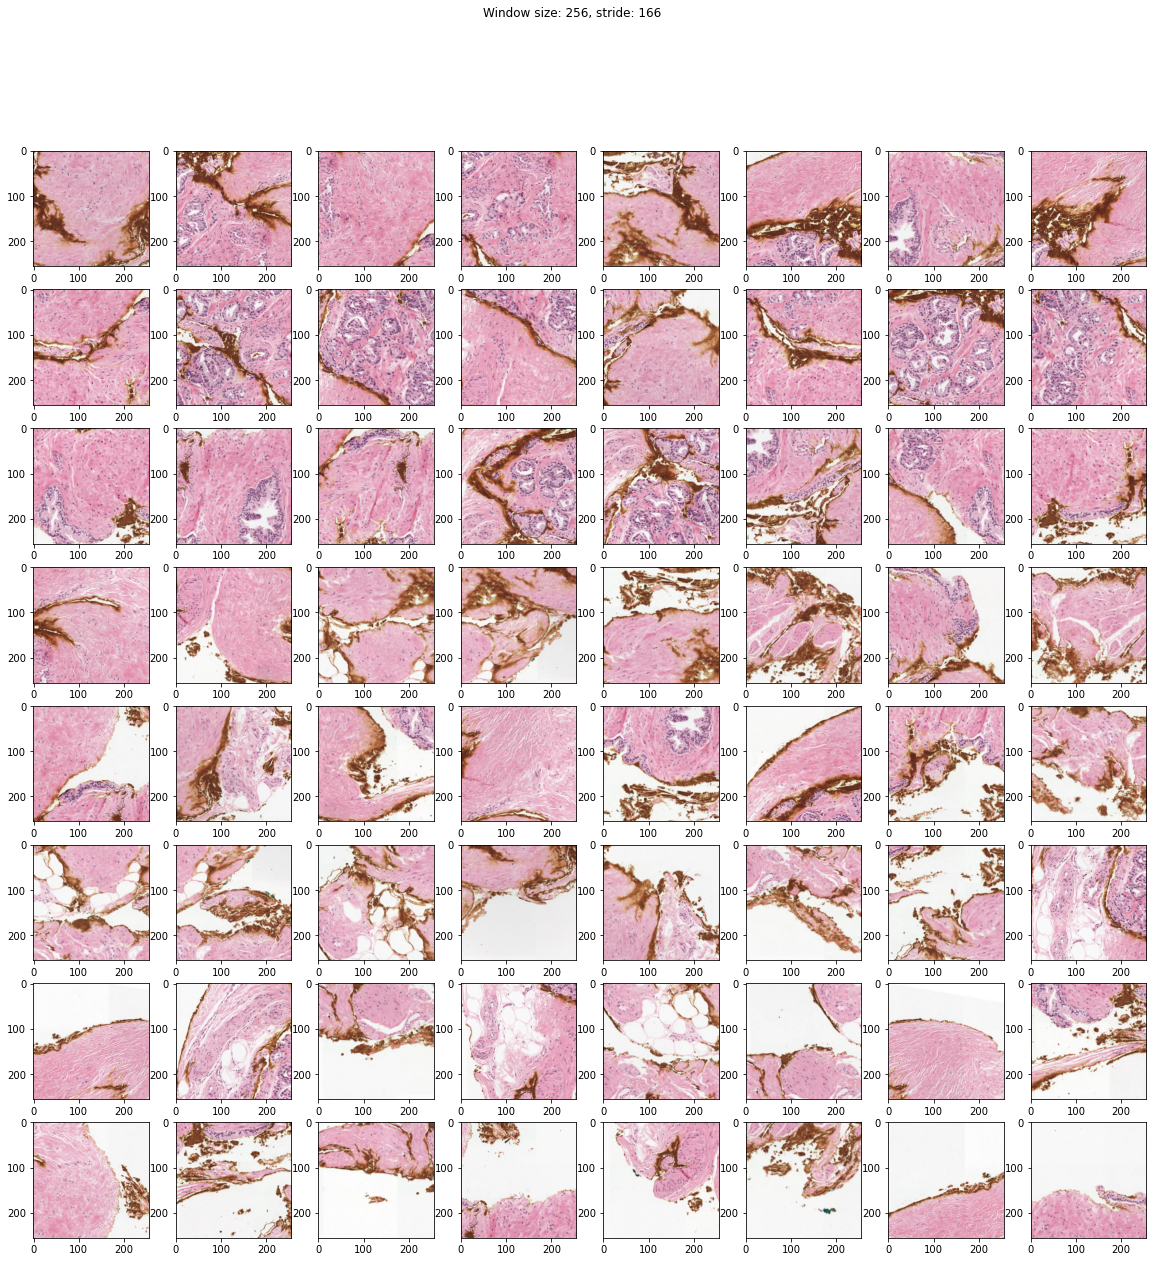

In [5]:
display_images(best_regions, 'Window size: 256, stride: 166')

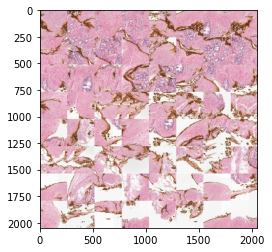

In [6]:
glued_img = glue_to_one_picture(best_regions, window_size=256, k=64)
plt.imshow(glued_img)

# Step 2: Make tiles of biopsies, select the best tiles, use mask_labels to determine isup_score, and store as small images

### I first need to understand how the masks look and how they differ depending on who the data providers is. We already know the differing practices of mask_label scores here (from Kaggle competition):

Radboud: Prostate glands are individually labelled. Valid values are: <br>
0: background (non tissue) or unknown<br>
1: stroma (connective tissue, non-epithelium tissue)<br>
2: healthy (benign) epithelium<br>
3: cancerous epithelium (Gleason 3)<br>
4: cancerous epithelium (Gleason 4)<br>
5: cancerous epithelium (Gleason 5)<br>
<br>
Karolinska: Regions are labelled. Valid values are:<br>
0: background (non tissue) or unknown<br>
1: benign tissue (stroma and epithelium combined)<br>
2: cancerous tissue (stroma and epithelium combined)<br>
<br>
### From the above, I have determined the following:
1) Radboud mask_labels will be useful in determining gleason scores of 3, 4, and 5, as well as healthy tissue (label codes 1 and 2)\
2) Karolinska mask_labels will be useful in determining benign tissue

Let's see first see:\
1) how many train_images have labels and <br>
2) how many labels do we have for each data provider

In [7]:
# Entire database (train.csv)
df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')

# Identifying images with masks
mask_file_names = os.listdir('../input/prostate-cancer-grade-assessment/train_label_masks')
mask_image_id = [file_name.replace('_mask.tiff','') for file_name in mask_file_names]
img_id = df['image_id'].values
df['mask']=[1 if x in mask_image_id else 0 for x in df.image_id]

# Creating database with only images that have masks
df_mask = df.loc[df['mask']==1]

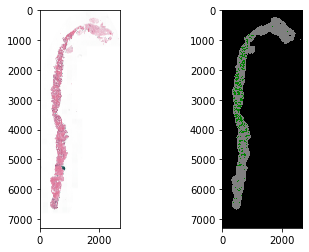

In [8]:
# Let's compare an image with its mask
image_id = np.random.choice(df_mask['image_id'],1)[0]
image_path = '../input/prostate-cancer-grade-assessment/train_images/'+ str(image_id) + '.tiff'
mask_path = '../input/prostate-cancer-grade-assessment/train_label_masks/'+ str(image_id) + '_mask.tiff'

image = np.asarray(skimage.io.MultiImage(image_path)[1])
mask = np.asarray(skimage.io.MultiImage(mask_path)[1])

cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
f, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[1].imshow(np.asarray(mask)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)

In [9]:
row_of_interest = df_mask.loc[df['image_id'] == '08b04f43997889865568c2c0d7bba8ab']
row_of_interest

image_id data_provider  isup_grade gleason_score  \
338  08b04f43997889865568c2c0d7bba8ab       radboud           3           4+3   

     mask  
338     1

In [10]:
image_folder = '../input/prostate-cancer-grade-assessment/train_images/'
mask_folder = '../input/prostate-cancer-grade-assessment/train_label_masks/'


def make_small_pics_w_label_mask(image_id, image_folder, mask_folder, window_size, stride, k):
    image_path = '../input/prostate-cancer-grade-assessment/train_images/'+ str(image_id) + '.tiff'
    mask_path = '../input/prostate-cancer-grade-assessment/train_label_masks/'+ str(image_id) + '_mask.tiff'
    image, best_coordinates, best_regions = generate_patches(image_path, window_size, stride, k)

    region_g_score = []
    mask_regions = {}
    mask_label = skimage.io.MultiImage(mask_path)[1]
    for i, tup in enumerate(best_coordinates):
        x, y = tup[0], tup[1]
        mask_regions[i] = mask_label[x : x+window_size, y : y+window_size, :]
        pic_name = str(image_id) + '_' + str(mask_regions[i].max()) +'.png'
        pic = Image.fromarray(best_regions[i])
        pic.save(pic_name)
        region_g_score.append(mask_regions[i].max())
    return region_g_score, mask_regions

In [11]:
window_size = 256
stride = 166
k = 64

region_g_score, mask_regions = make_small_pics_w_label_mask(image_id, image_folder, mask_folder, window_size, stride, k)
np.array(region_g_score).T

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=uint8)

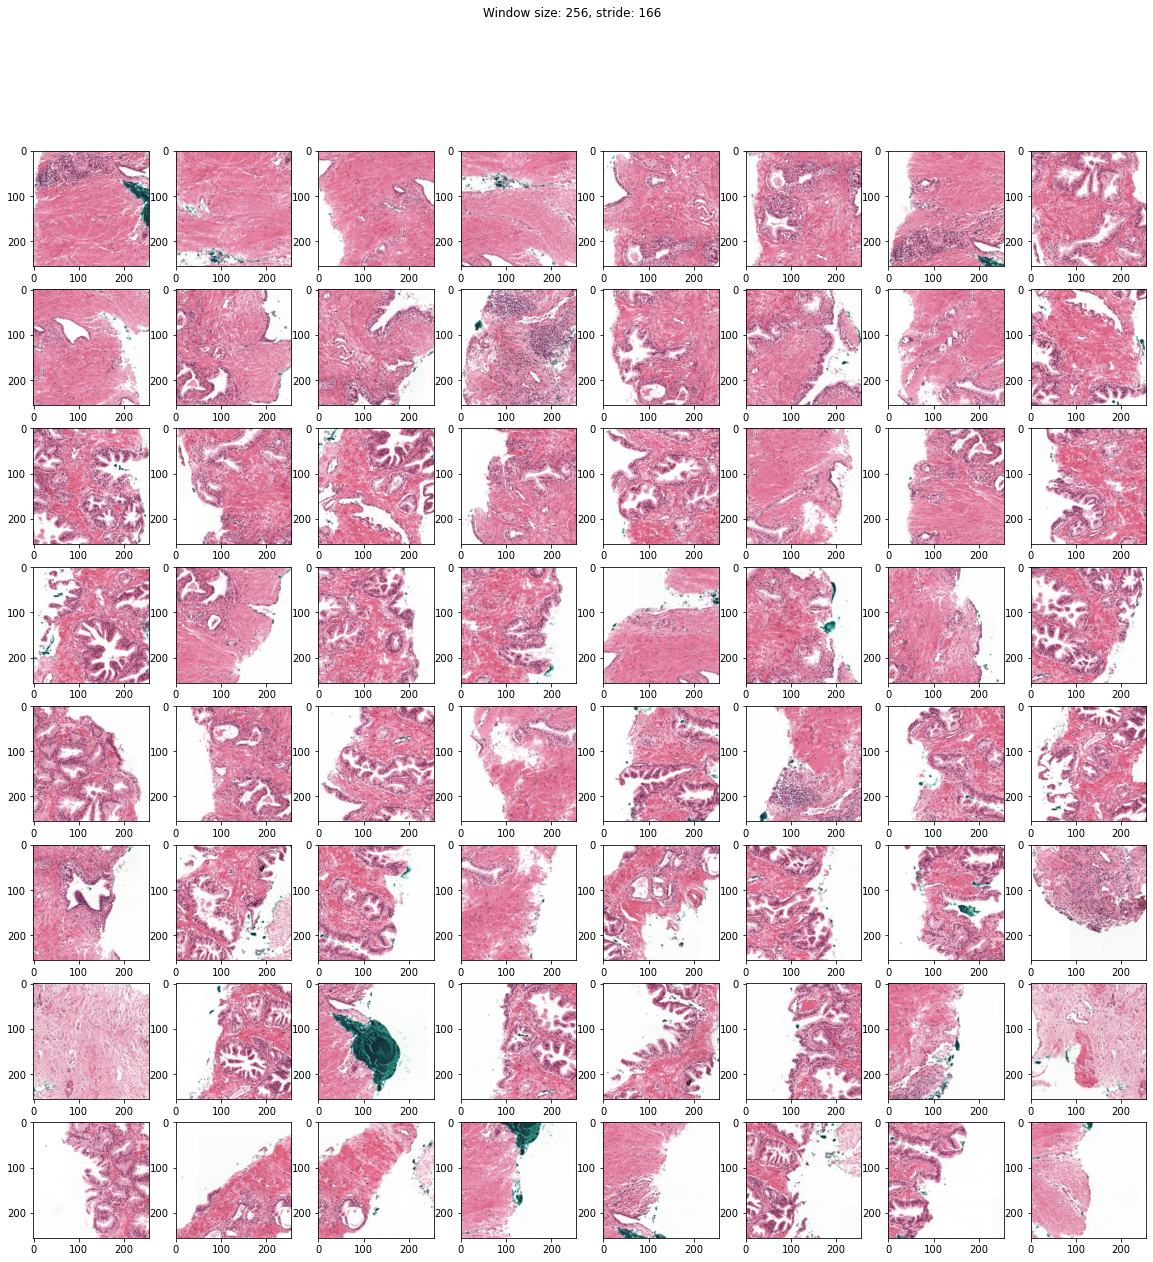

In [12]:
image_path = image_path

image, best_coordinates, best_regions = generate_patches(image_path, window_size, stride, k=64)
display_images(best_regions, 'Window size: 256, stride: 166')

In [13]:
pd.DataFrame(region_g_score).value_counts()

2    64
dtype: int64

In [14]:
def display_mask_images(mask_regions, title):
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    
    for i, region in mask_regions.items():
        ax[i//8, i%8].imshow(np.asarray(region)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)            

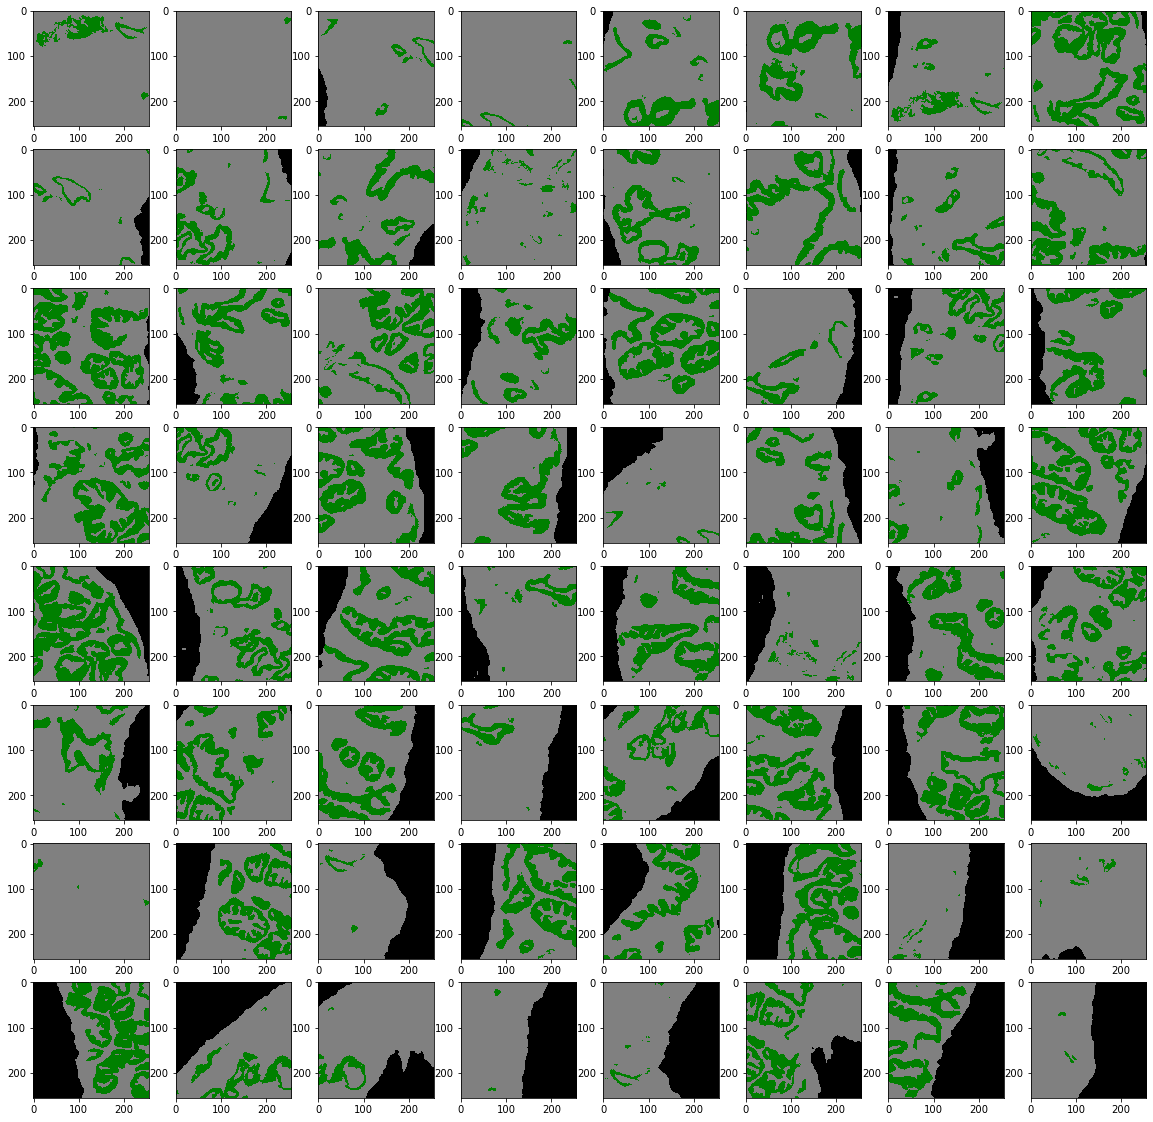

In [15]:
display_mask_images(mask_regions, title="test")

In [16]:
make_small_pics_w_label_mask('08b04f43997889865568c2c0d7bba8ab', image_folder, mask_folder, window_size, stride, 64)

([4,
  4,
  4,
  4,
  4,
  4,
  4,
  3,
  4,
  4,
  4,
  3,
  4,
  4,
  4,
  2,
  4,
  3,
  4,
  2,
  4,
  4,
  3,
  2,
  2,
  3,
  4,
  3,
  2,
  3,
  2,
  2,
  3,
  4,
  3,
  3,
  2,
  4,
  2,
  3,
  4,
  4,
  3,
  4,
  2,
  3,
  2,
  3,
  3,
  4,
  2,
  2,
  2,
  4,
  2,
  1,
  4,
  2,
  2,
  4,
  4,
  3,
  2,
  4],
 {0: array([[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         ...,
  
         [[4, 0, 0],
          [4, 0, 0],
          [1, 0, 0],
          ...,
          [4, 0, 0],
          [4, 0, 0],
          [4, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
 

# The objective was to create 100,000's of smaller images that heach had their own Gleason score. Then the model would have been train on small, highly accurate pictures of biopsies with assigned labels. Then, had there been more time, the idea would have been to break new images into smaller pictures, get a gleason score for each small image, then determine the gleason score of the overall biopsy from the scores of the individual, smaller pictures.